In [1]:
# https://github.com/shenweichen/DeepCTR/blob/a94a8ece8374339eda162df66db1324df56aaba1/deepctr/layers/interaction.py#L683

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os,sys,inspect
import gc
from tqdm import tqdm
import random

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from load import *
from evals import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input, Embedding, Flatten, Multiply
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
        
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

In [4]:
df = load_data('../data/ml-100k/u.data', threshold=3)
uuid = df['userId'].unique()
uiid = df['movieId'].unique()


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [6]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((85000, 2), (15000, 2))

In [7]:
# class Attention_Emb(layers.Layer):
#     def __init__(self, att_emb_size, head_num, use_resid=True):
#         super(Attention_Emb, self).__init__()
        
#         self.att_emb_size = att_emb_size
#         self.head_num = head_num
#         self.use_resid = use_resid
        
#         self.flatten = Flatten()
        
#     def build(self, input_shape):
#         units = self.att_emb_size * self.head_num
        
#         self.W_q = Dense(units)
#         self.W_k = Dense(units)
#         self.W_v = Dense(units)
#         if self.use_resid:
#             self.W_res = Dense(units)
            
#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
#         q = self.W_q(inputs)
#         k = self.W_k(inputs)
#         v = self.W_v(inputs)

#         q = tf.transpose(tf.reshape(q, (batch_size, -1, self.head_num, self.att_emb_size)), [0, 2, 1, 3])
#         k = tf.transpose(tf.reshape(k, (batch_size, -1, self.head_num, self.att_emb_size)), [0, 2, 1, 3])
#         v = tf.transpose(tf.reshape(v, (batch_size, -1, self.head_num, self.att_emb_size)), [0, 2, 1, 3])

#         att_score = tf.matmul(q, k, transpose_b=True)
#         att_score = tf.nn.softmax(att_score, -1)

#         out = tf.matmul(att_score, v)
        
#         out = tf.transpose(out, [0, 2, 1, 3])
#         out = tf.reshape(out, (batch_size, -1, self.head_num*self.att_emb_size))

#         if self.use_resid:
#             out = out + self.W_res((inputs))
            
#         out = tf.nn.relu(out)
        
#         return out
        
        
class MHA(layers.Layer):
    def __init__(self, emb_size, head_num, use_resid=True):
        super(MHA, self).__init__()
        
        self.emb_size = emb_size
        self.head_num = head_num
        self.use_resid = use_resid
        
        self.flatten = Flatten()
        
        self.att = tfa.layers.MultiHeadAttention(emb_size, head_num)
        
    def build(self, input_shape):
        units = self.emb_size * self.head_num
        
        self.W_q = Dense(units)
        self.W_k = Dense(units)
        self.W_v = Dense(units)
        if self.use_resid:
            self.W_res = Dense(units)
            
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        q = self.W_q(inputs)
        k = self.W_k(inputs)
        v = self.W_v(inputs)
        
        out = self.att([q, k, v])

        if self.use_resid:
            out = out + self.W_res((inputs))
            
        out = tf.nn.relu(out)
        
        return out

In [8]:
class AutoInt(tf.keras.Model):
    def __init__(self, x_dims, latent_dim, att_sizes, att_heads, l2_emb=1e-4):
        super(AutoInt, self).__init__()
        
        self.x_dims = x_dims
        self.latent_dim = latent_dim

        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
        
        self.linear = Dense(1)
        
        self.att_layers = [MHA(a, h) for a, h in zip(att_sizes, att_heads)]
        
        self.flatten =  Flatten()
        
    def call(self, inputs):
        emb = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])
        
        att = emb
        for att_layer in self.att_layers:
            att = att_layer(att)
        
        out = self.linear(self.flatten(att))
        
        return out

In [9]:
autoint = AutoInt((len(uuid), len(uiid)), 8, [8, 8], [2, 2])

In [10]:
autoint.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam(2e-4))

In [11]:
hist = autoint.fit(tr_X, 
           train['rating'].values,
          epochs=10,
          shuffle=True,
          validation_split=0.1)

Epoch 1/10
2391/2391 [==============================] - 17s 7ms/step - loss: 0.6168 - val_loss: 0.5763
Epoch 2/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5602 - val_loss: 0.5716
Epoch 3/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5537 - val_loss: 0.5695
Epoch 4/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5507 - val_loss: 0.5680
Epoch 5/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5466 - val_loss: 0.5663
Epoch 6/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5390 - val_loss: 0.5655
Epoch 7/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5333 - val_loss: 0.5668
Epoch 8/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5293 - val_loss: 0.5672
Epoch 9/10
2391/2391 [==============================] - 16s 7ms/step - loss: 0.5261 - val_loss: 0.5678
Epoch 10/10
2391/2391 [==============================] - 16s 7ms/step - l

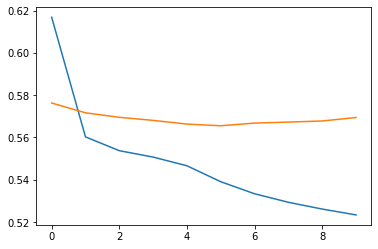

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [13]:
pred = autoint.predict(test_X)


In [14]:
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

0.7214666666666667

In [15]:
from sklearn.metrics import precision_score, recall_score,  roc_auc_score, precision_recall_fscore_support

print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

0.787184255606191
0.7213903743315508
0.8108920413560952
